In [52]:
# Core imports
import numpy as np
from numpy import linalg as la 
import heyoka as hk
import pykep as pk
import pandas as pd
import math
from numpy.lib.function_base import append
from scipy.integrate import odeint

# Sys imports
import time

# Plot imports
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Other imports
import dromo_const as const

%matplotlib notebook

In [53]:
# Auxiliary function
def state2orb(r0, v0, Gparam, angle_unit):
    """
    Converts from state vector to orbital parameters
    units:
    r0 in km
    v0 in km/s
    Gparam in km^3/s^2
    a in km
    e is [-]
    angles in radiants (default) or degrees
    """
    h = np.cross(r0, v0)
    h_norm = np.linalg.norm(h)
    cos_inclination = h[2]/h_norm       # since h scalar product z = h_norm*1*cos(i) = h_3

    if np.linalg.norm(cos_inclination) >= 1:
        cos_inclination = np.sign(cos_inclination)
    inclination = math.acos(cos_inclination)
    inclination_d = math.degrees(inclination)

    if inclination == 0 or inclination == np.pi :
        node_line = [1, 0, 0] # None  # pick the x-axis as your line of Nodes, which is undefined as the orbital and equatorial plane coincide
        RAAN = 0  # None 
        RAAN_r = 0
    else :
        node_line = np.cross([0, 0, 1], h)/(np.linalg.norm(np.cross([0, 0, 1], h))) # cross vector is not commutative
        cos_RAAN = node_line[0]
        if np.linalg.norm(cos_RAAN) >= 1:
            cos_RAAN = np.sign(cos_RAAN)
        RAAN = math.acos(cos_RAAN)
        RAAN_d = math.degrees(RAAN)

    if node_line[1] < 0:
        RAAN = 2*np.pi - RAAN
        RAAN_d = math.degrees(RAAN)

    # From the Laplace vector equation 
    e = (np.cross(v0, h))/Gparam - r0/np.linalg.norm(r0)
    e_norm = np.linalg.norm(e)

    if e_norm < math.pow(10, -5):
        # for circular orbits choose r0 as the apse line to count the true anomaly and define the argument of perigee
        cos_arg_perigee = np.dot(r0, node_line)/np.linalg.norm(r0)
        if np.linalg.norm(cos_arg_perigee) >= 1:
            cos_arg_perigee = np.sign(cos_arg_perigee)
        arg_perigee = math.acos(cos_arg_perigee)
        arg_perigee_d = math.degrees(arg_perigee)
        if r0[2] < 0:
            arg_perigee = 2*np.pi - arg_perigee
            arg_perigee_d = math.degrees(arg_perigee)
        # arg_perigee =  # None 
    else :
        cos_arg_perigee = np.dot(e, node_line)/e_norm
        if np.linalg.norm(cos_arg_perigee) >= 1:
            cos_arg_perigee = np.sign(cos_arg_perigee)
        arg_perigee = math.acos(cos_arg_perigee)
        arg_perigee_d = math.degrees(arg_perigee)
        if e[2] < 0: # e1,e2,e3 dot 0,0,1
            arg_perigee = 2*np.pi - arg_perigee
            arg_perigee_d = math.degrees(arg_perigee)

    perigee = (np.linalg.norm(h)**2/Gparam) * (1/(1+e_norm))
    apogee  = (np.linalg.norm(h)**2/Gparam) * (1/(1-e_norm))

    if apogee < 0:
        # in the case of an hyperbolic orbit
        apogee = - apogee

    semi_major_axis = (perigee+apogee)/2
    T = (2*np.pi/math.sqrt(Gparam)) * math.pow(semi_major_axis, 3/2)  # orbital period (s)

    if e_norm < math.pow(10, -5):
        true_anomaly = 0
    else :
        cos_true_anomaly = np.dot(e, r0)/(e_norm*np.linalg.norm(r0))
        if np.linalg.norm(cos_true_anomaly) >= 1:
            cos_true_anomaly = np.sign(cos_true_anomaly)
        true_anomaly = math.acos(cos_true_anomaly)
        true_anomaly_d = math.degrees(true_anomaly)

    u_r  = r0/np.linalg.norm(r0)
    if np.dot(v0, u_r) < 0:
        # past apogee
        true_anomaly = 2*np.pi - true_anomaly   
        true_anomaly_d = math.degrees(true_anomaly)
        
    if angle_unit == "r":
        return semi_major_axis, e_norm, inclination, RAAN, arg_perigee, true_anomaly
    elif angle_unit == "d":
        return semi_major_axis, e_norm, inclination_d, RAAN_d, arg_perigee_d, true_anomaly_d
    else:
        raise("Insert a valid unit for the angle, r for radians, d for degree")

In [54]:
#create heyoka variables
X,Y,Z = hk.make_vars("X","Y","Z")
VX,VY,VZ = hk.make_vars("VX","VY","VZ")

In [55]:
#right hand side
GMe = const.GMe
Re = const.Re
J2 = const.J2

#Earth's Keplerian terms
#r = math.sqrt(X**2 + Y**2 + Z**2) this is not supported by heyoka
magR2 = X**2 + Y**2 + Z**2
r = (magR2)**(1/2)

fKepX = -GMe*X/(magR2**(3./2))
fKepY = -GMe*Y/(magR2**(3./2))
fKepZ = -GMe*Z/(magR2**(3./2))

#Earth's J2 terms
fJ2X = (-GMe/(r**3)) * X + ( (3/2)*J2*GMe*Re**2/r**4 ) * (X/r)*(5*(Z**2/r**2) -1)
fJ2Y = (-GMe/(r**3)) * Y + ( (3/2)*J2*GMe*Re**2/r**4 ) * (Y/r)*(5*(Z**2/r**2) -1)
fJ2Z = (-GMe/(r**3)) * Z + ( (3/2)*J2*GMe*Re**2/r**4 ) * (Z/r)*(5*(Z**2/r**2) -3)

In [56]:
#EOMs
dXdt = VX
dYdt = VY
dZdt = VZ
dVXdt = fKepX + fJ2X 
dVYdt = fKepY + fJ2Y 
dVZdt = fKepZ + fJ2Z 

In [57]:
# Initial conditions (ic)
t0 = 0.0 #[in seconds past the epoch 0]
r0 = np.array([0.0, -5888.9727, -3400.0]) #km   (class 'numpy.ndarray')
v0 = np.array([10.691338, 0.0, 0.0])      #km/s

ic = [*r0, *v0]

print('Compiling the Taylor integrator ... (this is done only once)')
start_time = time.time()

ta = hk.taylor_adaptive(sys = [(X,dXdt),(Y,dYdt),(Z,dZdt),(VX,dVXdt),(VY,dVYdt),(VZ,dVZdt)],
                        state = ic,
                        time = t0,
                        tol = 1e-16,
                        compact_mode = True)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))

print("\nHeyoka Taylor integrator:\n", ta)

Compiling the Taylor integrator ... (this is done only once)
Done, in
--- 0.4344003200531006 seconds ---

Heyoka Taylor integrator:
 Taylor order            : 20
Dimension               : 6
Time                    : 0.0000000000000000
State                   : [0.0000000000000000, -5888.9727000000003, -3400.0000000000000, 10.691338000000000, 0.0000000000000000, 0.0000000000000000]



In [58]:
# How many years to integrate
tmax = 288.12768941*24*60*60 #[sec]

# How often to log the state
dt = 3600 #[sec]

# Here we redefine the initial conditions since we may want to change them without recompiling the integrator
ta.time = t0
# Note the python syntax to assign directly the array elements. Here necessary
# as heyoka does not allow to change the memory location of the state
ta.state[:] =  [*r0, *v0] #[x0,y0,z0,vx0,vy0,vz0]

In [59]:
print('Numerically propagating the orbit for {} days'.format(tmax/(24*3600)))

tgrid = np.linspace(t0, tmax, int(1 + tmax/dt), endpoint = True)

start_time = time.time()
out = ta.propagate_grid(tgrid)
end_time = time.time()

print('Done, in');
print("--- %s seconds ---" % (end_time - start_time))
sol = out[4] 
size = np.shape(sol)
print(f'the shape of the solution (cartesian form) is {size}')
#np.savetxt('sim_hK_cart_002.txt', sol)

Numerically propagating the orbit for 288.1276894100001 days
Done, in
--- 0.4477698802947998 seconds ---
the shape of the solution (cartesian form) is (6916, 6)


In [67]:
# Convert to Keplerian Elements
sol_el = np.zeros(size)

for i, cartesian in enumerate(sol):
    sol_el[i] = state2orb(cartesian[:3], cartesian[-3:], GMe, "r")
    
#np.savetxt('sim_hK_el_002.txt', sol_el)

<IPython.core.display.Javascript object>


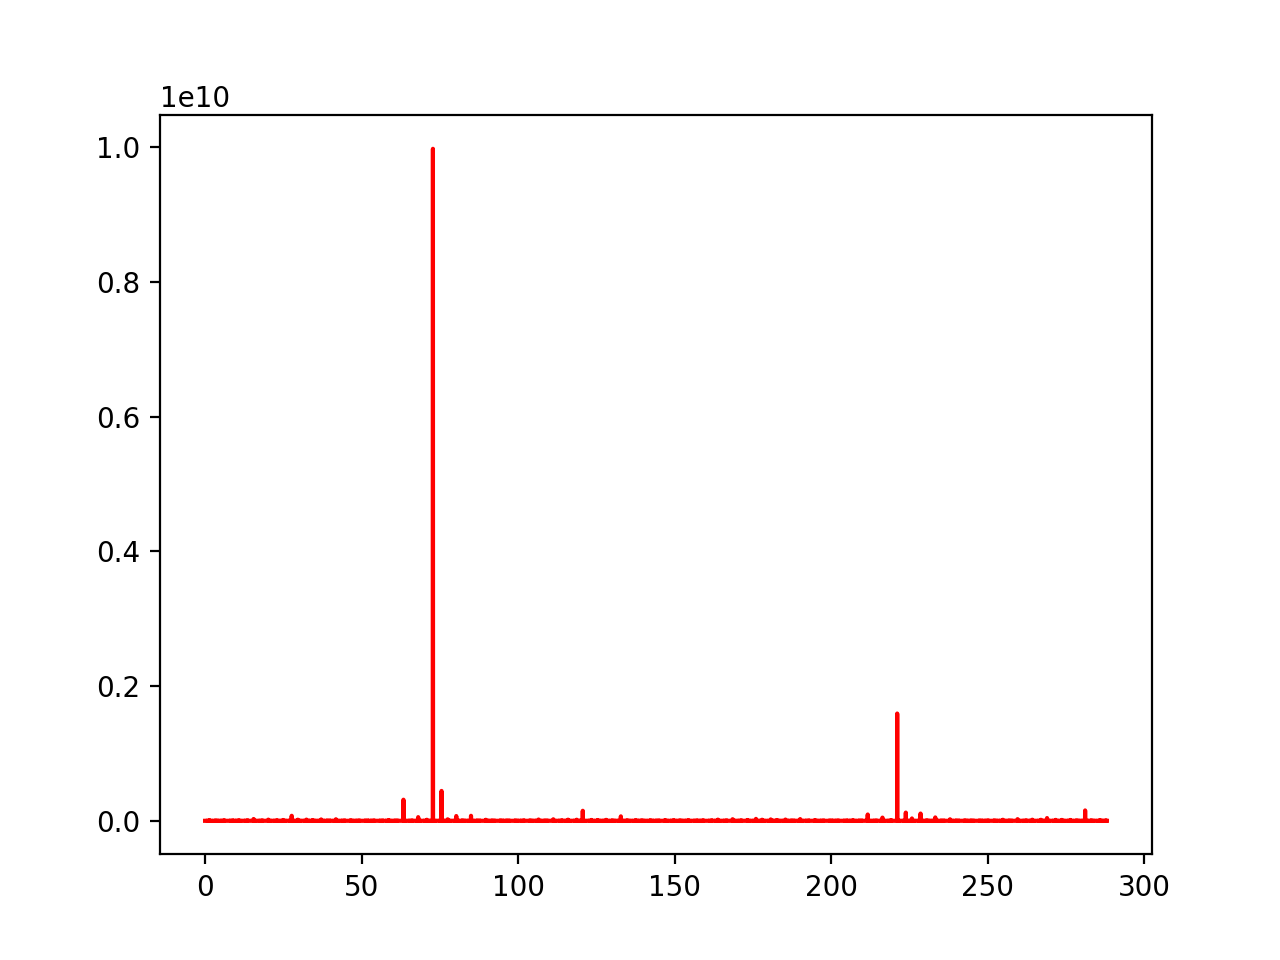

In [76]:
plt.figure(0)
plt.plot(tgrid * pk.SEC2DAY, sol_el[:, 0], "red")

<IPython.core.display.Javascript object>


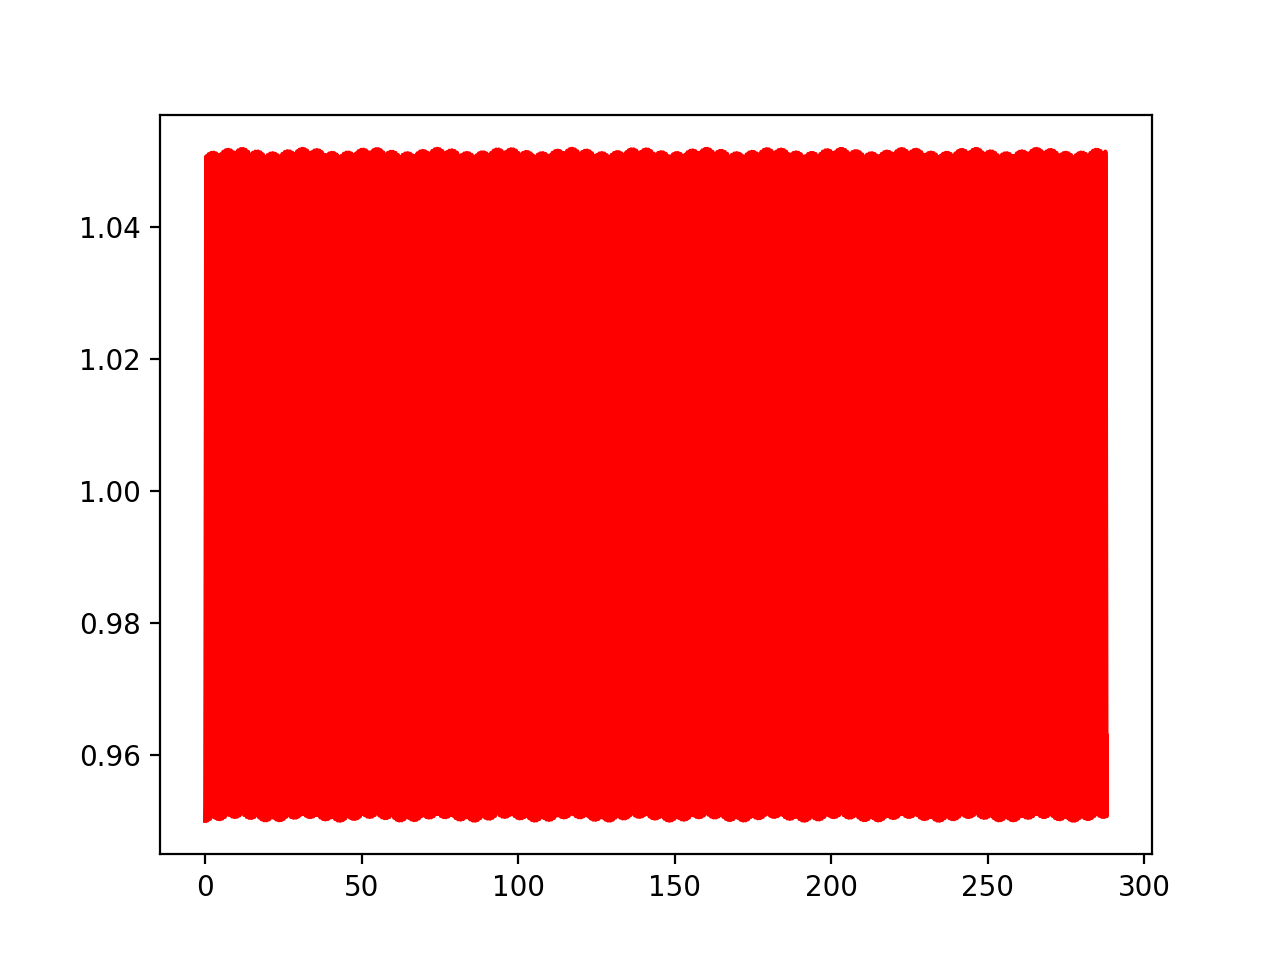

In [70]:
plt.figure(1)
plt.plot(tgrid * pk.SEC2DAY, sol_el[:, 1], "red")


<IPython.core.display.Javascript object>


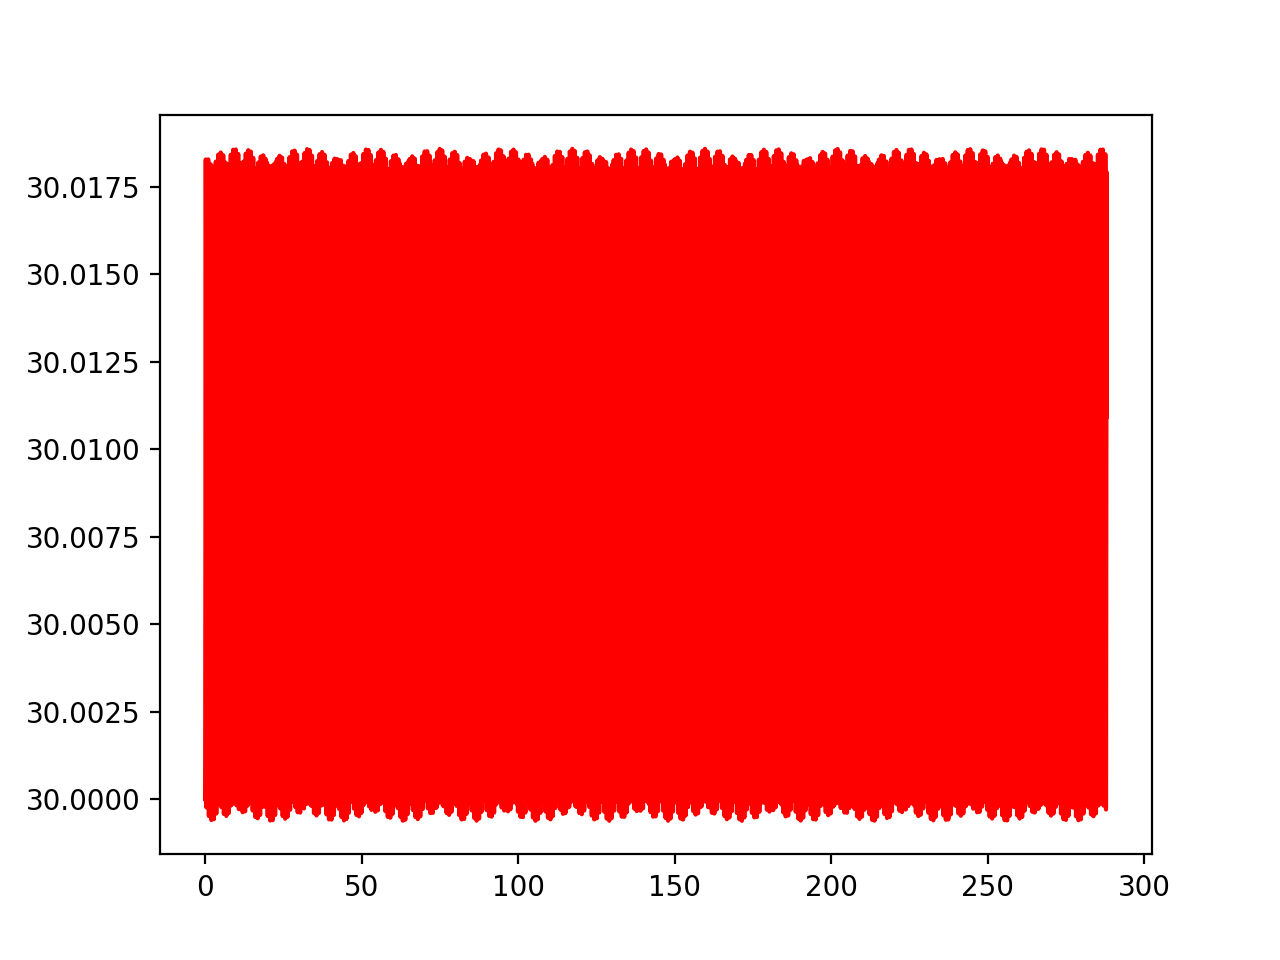

In [71]:
plt.figure(2)
plt.plot(tgrid * pk.SEC2DAY, sol_el[:, 2]*180/np.pi, "red")


<IPython.core.display.Javascript object>


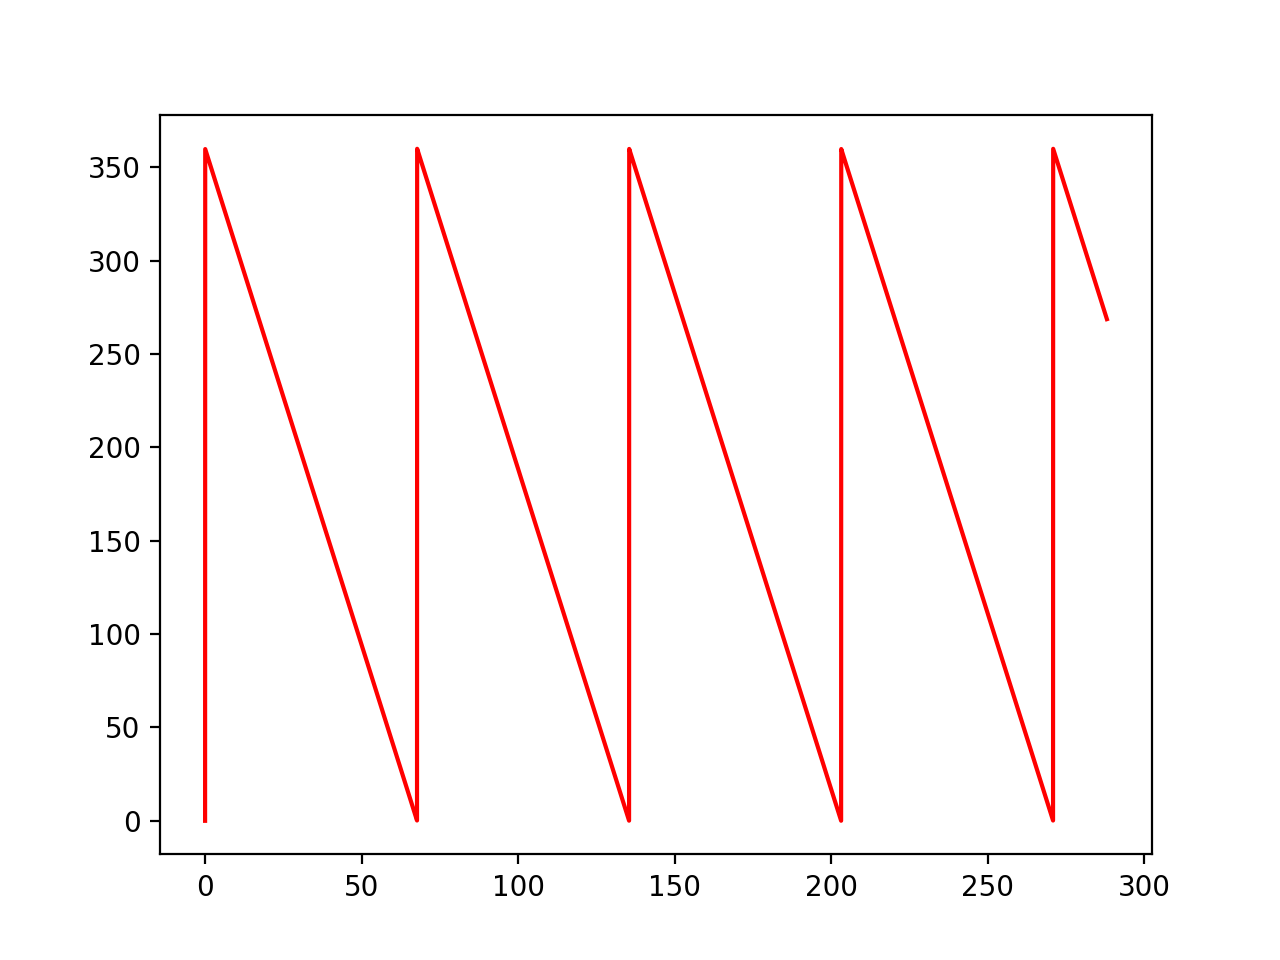

In [72]:
plt.figure(3)
plt.plot(tgrid * pk.SEC2DAY, sol_el[:, 3]*180/np.pi, "red")


<IPython.core.display.Javascript object>


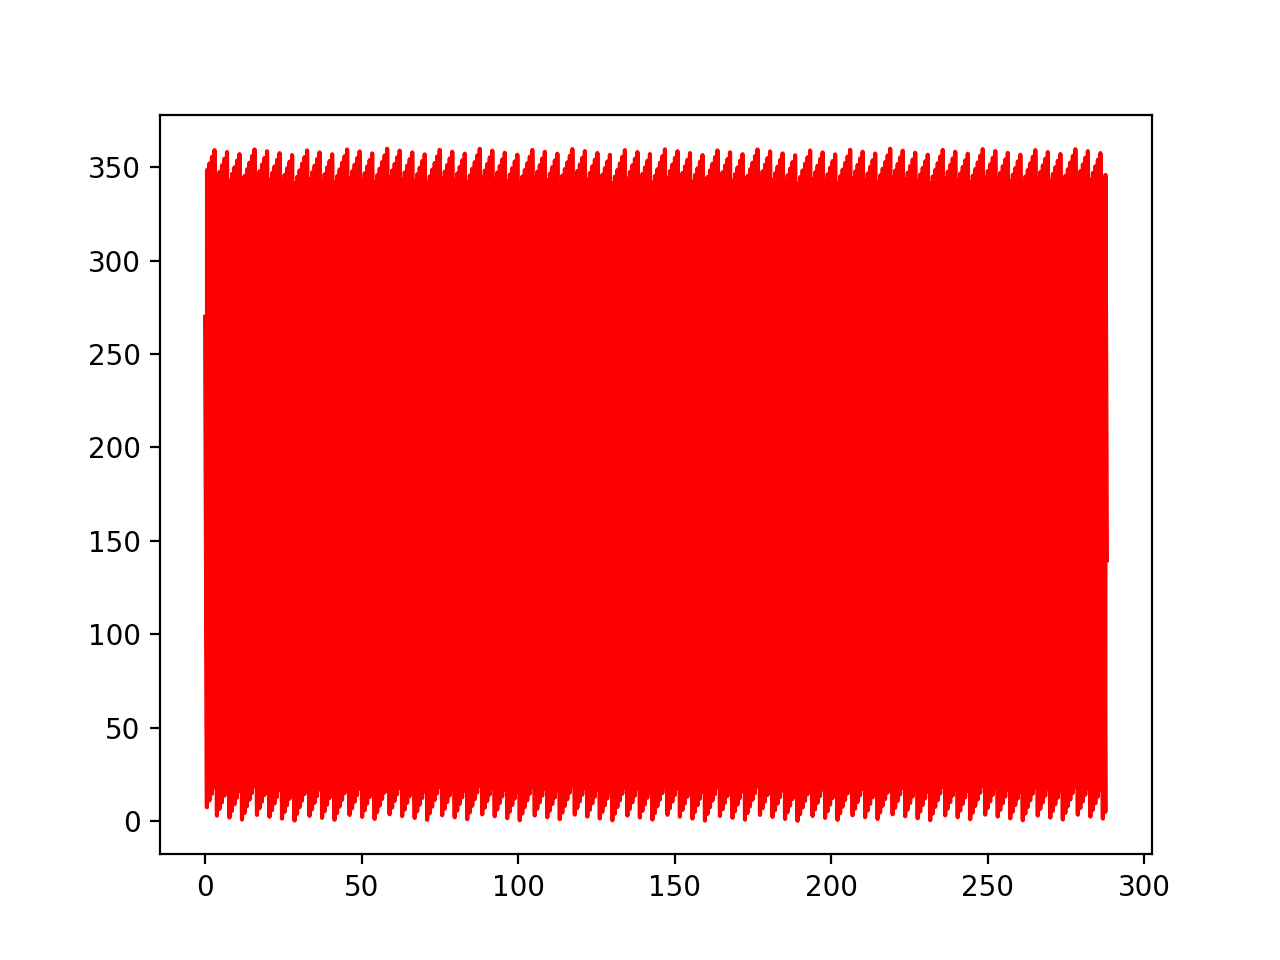

In [73]:
plt.figure(4)
plt.plot(tgrid * pk.SEC2DAY, sol_el[:, 4]*180/np.pi, "red")


<IPython.core.display.Javascript object>


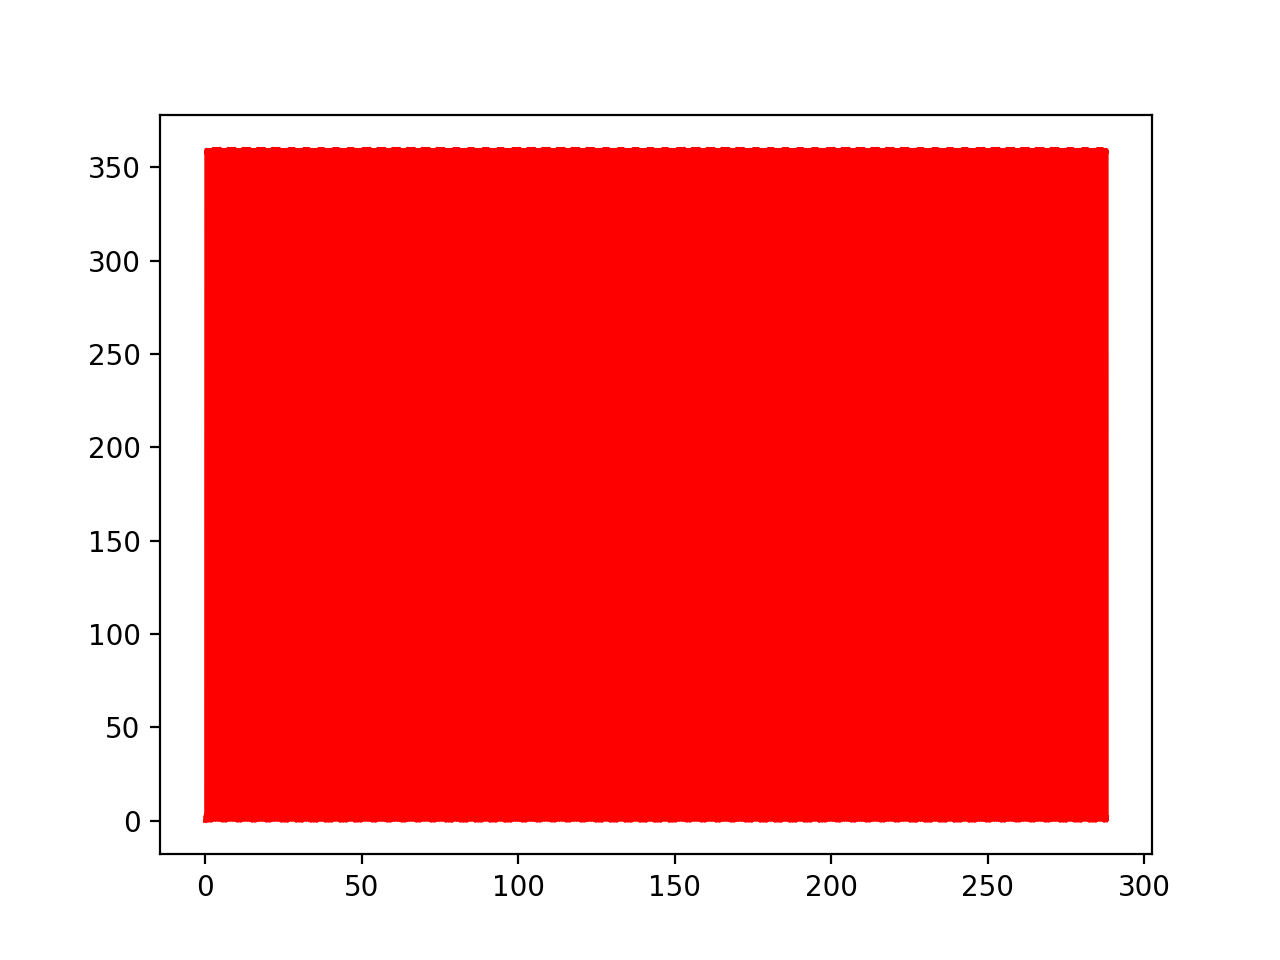

In [74]:
plt.figure(5)
plt.plot(tgrid * pk.SEC2DAY, (sol_el[:, 5]*180/np.pi), "red")